In [29]:
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
#from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion
import glob
from PIL import Image
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
#from sklearn.metrics import accuracy_score
import tensorflow as tf


TRAIN_DIR = 'C:\\Users\Dell\\Downloads\\catsVsdogs\\DATASET\\train\\h(0)s(0)v'
TEST_DIR = 'C:\\Users\\Dell\\Downloads\\catsVsdogs\\DATASET\\train\\hsv2'
IMG_SIZE = 50
LR = 1e-3

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [3]:
def create_train_data():
    train_images = []
    train_labels = []
    for img in os.listdir(TRAIN_DIR):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img=Image.open(path)
        img = img.resize((IMG_SIZE,IMG_SIZE), Image.ANTIALIAS)
    
        train_images.append(np.array(img))
        train_labels.append(np.array(label))
    shuffle(train_images)
    shuffle(train_labels)
    np.save('train_images.npy', train_images)
    np.save('train_labels.npy', train_labels)
    return train_images, train_labels

In [39]:
def process_test_data():
    test_images = []
    test_labels = []
    for img in os.listdir(TEST_DIR):
        label = label_img(img)
        path = os.path.join(TEST_DIR,img)
        img=Image.open(path)
        img = img.resize((IMG_SIZE,IMG_SIZE), Image.ANTIALIAS)
    
        test_images.append(np.array(img))
        test_labels.append(np.array(label))
    shuffle(test_images)
    shuffle(test_labels)
    np.save('test_images.npy', test_images)
    np.save('test_labels.npy', test_labels)
    return test_images, test_labels

In [5]:
train_images, train_labels = create_train_data()

In [6]:
#train_images = train_images.reshape((17500,7500))
#print(np.shape(train_images))
train_images=np.asarray(train_images)
train_images = train_images.reshape((24849,7500))
train_labels = np.asarray(train_labels)
np.shape(train_labels)
np.shape(train_labels)
np.shape(train_images)

(24849, 7500)

In [40]:
test_images, test_labels = process_test_data()

In [41]:
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)
np.shape(test_images)
#test_labels
test_images = test_images.reshape((2000,7500))
np.shape(test_images)
#np.shape(test_labels)

(2000, 7500)

In [7]:
split_size = int(train_images.shape[0]*0.7)
split_size

17394

In [8]:
train_images, val_images, train_labels, val_labels = train_images[:split_size], train_images[split_size:], train_labels[:split_size], train_labels[split_size:]

In [9]:
np.shape(train_images), np.shape(val_images), np.shape(train_labels), np.shape(val_labels)

((17394, 7500), (7455, 7500), (17394, 2), (7455, 2))

In [43]:
np.shape(test_images), np.shape(test_labels)
test_images=test_images.reshape(2000, 7500)
np.shape(test_images)

(2000, 7500)

In [44]:
val_labels[:5, :]

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1]])

In [45]:
# Hyper-parameters
epochs = 10             # Total number of training epochs
batch_size = 100        # Training batch size
display_freq = 100      # Frequency of displaying the training results
learning_rate = 0.001 # The optimization initial learning rate

h1 = 200                # number of nodes in the 1st hidden layer

In [12]:
# weight and bais wrappers
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)
def get_next_batch(x, y, start, end):
    batch_images = x[start:end]
    batch_labels = y[start:end]
    return batch_images, batch_labels

In [13]:
#Helper-function for creating a fully-connected layer
def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    in_dim1 = x.get_shape()[1]
    W = weight_variable(name, shape=[in_dim1, num_units])
    b = bias_variable(name, [num_units])
    layer = tf.matmul(x, W)
    layer += b
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer
 

In [14]:
# Create the graph for the linear model
# Placeholders for inputs (x) and outputs(y)
x = tf.placeholder(tf.float32, shape=[None, 7500], name='X')
y = tf.placeholder(tf.float32, shape=[None, 2], name='Y')

In [15]:
# Create a fully-connected layer with h1 nodes as hidden layer
fc1 = fc_layer(x, h1, 'fullconc_9', use_relu=True)
# Create a fully-connected layer with n_classes nodes as output layer
output_logits = fc_layer(fc1, 2, 'OUT_9', use_relu=False)

In [16]:
# Define the loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# Network predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions') 
type(cls_prediction)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



tensorflow.python.framework.ops.Tensor

In [17]:
# Create the op for initializing all variables
init = tf.global_variables_initializer()

In [18]:
# Create an interactive session (to keep the session in the other cells)
sess = tf.InteractiveSession()
# Initialize all variables
sess.run(init)
# Number of training iterations in each epoch
num_tr_iter = int(len(train_labels) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    # Randomly shuffle the training data at the beginning of each epoch 
    #x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        batch_images, batch_labels = get_next_batch(train_images, train_labels, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {x: batch_images, y: batch_labels}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict=feed_dict_batch)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_valid = {x: val_images[:1000], y: val_labels[:1000]}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=160.74,	Training Accuracy=51.0%
iter 100:	 Loss=0.70,	Training Accuracy=43.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.69, validation accuracy: 52.6%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.70,	Training Accuracy=48.0%
iter 100:	 Loss=0.70,	Training Accuracy=41.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.69, validation accuracy: 52.0%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.69,	Training Accuracy=50.0%
iter 100:	 Loss=0.69,	Training Accuracy=45.0%
---------------------------------------------------------
Epoch: 3, validation loss: 0.69, validation accuracy: 52.2%
---------------------------------------------------------
Training epoch: 4
iter   0:	 Loss=0.69,	Training Accuracy=49.0%
iter 100:	 Loss=0.70,	Training Accuracy=41.0%
------------------------------

In [46]:
feed_dict_test = {x: test_images[:3000], y: test_labels[:3000]}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

---------------------------------------------------------
Test loss: 3.31, test accuracy: 52.5%
---------------------------------------------------------


In [49]:
import matplotlib.pyplot as plt
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(50, 50, 3), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {}".format(cls_true[i])
        else:
            if cls_true[i]==0:
                ax_title = "Cat"
            elif cls_true[i]==1:
                ax_title = "Dog"                    
        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)

def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

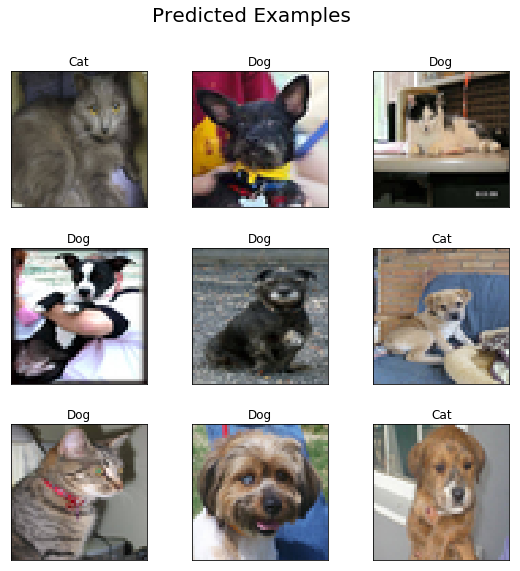

In [51]:
# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(test_labels[:3000], axis=1)
plot_images(test_images, cls_true, cls_pred, title='Predicted Examples')
plt.show()